In [ ]:
import itertools
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Flatten, TimeDistributed, Dropout, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm_notebook
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Define constants
person_count = 5
max_frames = 280


In [2]:
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [3]:
csv_dir = "dataset/csvs"

csv_files = os.listdir(csv_dir)

train_files, test_files = train_test_split(csv_files, train_size=0.8)

y_test_vals = []

minmax_scale = preprocessing.MinMaxScaler()
        
for file_name in tqdm_notebook(csv_files):
    csv = pd.read_csv(csv_dir + "/" + file_name)
    if len(csv) > 0:
        for label in csv.columns.values[2:]:
            minmax_scale = preprocessing.MinMaxScaler().partial_fit(csv[[label]])

In [4]:
def prepare_data(file_names, scaler, limit=0):
    x = []
    y = []
    if limit != 0:
        file_names = file_names[:limit]
        
    
        
    for file_name in tqdm_notebook(file_names):

        csv = pd.read_csv(csv_dir + "/" + file_name)

        current_frame = 0

        violent = 0
        
        if len(csv) > 0:
            violent = csv.violent[0]

            csv = csv.drop('violent',axis=1)

            labels = csv.columns.values

            for label in labels[2:]:
                csv[[label]] = scaler.transform(csv[[label]])

            data = csv.to_numpy()

            val_cumulative = {}
            frame_ids = set()
            for person in data:
                frame_ids.add(person[0])
                frame, person_id = person[:2]

                vel_array = []
                for vel in range(5, 70, 4):
                    vel_array.append(vel)

                total_vel = sum(vel_array)

                if person_id in val_cumulative:
                    val_cumulative[person_id] += total_vel
                else:
                    val_cumulative[person_id] = 0


            val_cumulative = {k: v for k, v in sorted(val_cumulative.items(), key=lambda item: item[1], reverse=True)}
            top_people = dict(itertools.islice(val_cumulative.items(), person_count))
            top_people_dataset = {}

            starter_map = {}
            for key in top_people.keys():
                starter_map[key] = np.zeros(68)

            for frame_id in frame_ids:
                # Trim to 280 if above
                if current_frame == max_frames:
                    break
                tmp_map = starter_map
                people = np.array([item for item in data if item[0] == frame_id and item[1] in top_people.keys()])
                for person in people:
                    tmp_map[person[1]] = person[2:]

                padded = list(tmp_map.values())

                for i in range(len(padded), person_count):
                    padded.append(np.zeros(68))

                top_people_dataset[frame_id] = np.asarray(padded)
                current_frame += 1


        # Pad to 280 frames if below
        for i in range(current_frame+1, max_frames+1):
            top_people_dataset[i] = []
            for j in range(0, person_count):
                top_people_dataset[i].append(np.zeros(68))

        tmp = np.asarray(list(top_people_dataset.values()))

        
        if len(tmp) != 280:
            print(file_name)
            continue
            
            
        x.append(tmp)
        
        if violent == 0:
            y.append(0)
        else:
            y.append(1)
        
    return (np.asarray(list(x)), np.asarray(list(y)))

In [5]:
x_train, y_train = prepare_data(train_files, minmax_scale)

NV_415_json.csv



In [6]:
for x in np.asarray(x_train):
    if len(x) != 280:
        print(len(x))

In [7]:
y_train.shape

(1599,)

In [8]:
model = Sequential()
optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.add(Conv2D(32, (3, 3), input_shape = (280, person_count, 68), activation = 'relu'))
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [9]:
history = model.fit(x_train, y_train, epochs=20, validation_split=0.2)

Train on 1279 samples, validate on 320 samples
Epoch 1/20
1279/1279 [==============================] - ETA: 53s - loss: 28.0675 - accuracy: 0.40 - ETA: 8s - loss: 111.1844 - accuracy: 0.46 - ETA: 3s - loss: 65.9541 - accuracy: 0.5341 - ETA: 2s - loss: 46.2145 - accuracy: 0.560 - ETA: 1s - loss: 37.4923 - accuracy: 0.562 - ETA: 0s - loss: 30.4378 - accuracy: 0.572 - ETA: 0s - loss: 25.5298 - accuracy: 0.584 - ETA: 0s - loss: 21.9778 - accuracy: 0.606 - 2s 2ms/sample - loss: 19.3300 - accuracy: 0.6192 - val_loss: 0.8915 - val_accuracy: 0.7125
Epoch 2/20
1279/1279 [==============================] - ETA: 0s - loss: 0.4205 - accuracy: 0.78 - ETA: 0s - loss: 0.4863 - accuracy: 0.79 - ETA: 0s - loss: 0.5336 - accuracy: 0.78 - ETA: 0s - loss: 0.5126 - accuracy: 0.79 - ETA: 0s - loss: 0.5333 - accuracy: 0.78 - ETA: 0s - loss: 0.5258 - accuracy: 0.78 - ETA: 0s - loss: 0.5103 - accuracy: 0.78 - ETA: 0s - loss: 0.5247 - accuracy: 0.77 - 1s 440us/sample - loss: 0.5246 - accuracy: 0.7756 - val_loss:

1279/1279 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 1.00 - ETA: 0s - loss: 0.0597 - accuracy: 0.99 - ETA: 0s - loss: 0.0699 - accuracy: 0.98 - ETA: 0s - loss: 0.0725 - accuracy: 0.98 - ETA: 0s - loss: 0.0722 - accuracy: 0.98 - ETA: 0s - loss: 0.0754 - accuracy: 0.98 - ETA: 0s - loss: 0.0762 - accuracy: 0.98 - ETA: 0s - loss: 0.0771 - accuracy: 0.98 - 1s 469us/sample - loss: 0.0765 - accuracy: 0.9820 - val_loss: 1.4056 - val_accuracy: 0.7125
Epoch 18/20
1279/1279 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 1.00 - ETA: 0s - loss: 0.0685 - accuracy: 0.98 - ETA: 0s - loss: 0.0614 - accuracy: 0.99 - ETA: 0s - loss: 0.0665 - accuracy: 0.98 - ETA: 0s - loss: 0.0672 - accuracy: 0.98 - ETA: 0s - loss: 0.0660 - accuracy: 0.98 - ETA: 0s - loss: 0.0693 - accuracy: 0.98 - ETA: 0s - loss: 0.0687 - accuracy: 0.98 - ETA: 0s - loss: 0.0727 - accuracy: 0.98 - 1s 456us/sample - loss: 0.0719 - accuracy: 0.9812 - val_loss: 1.3877 - val_accuracy: 0.7125


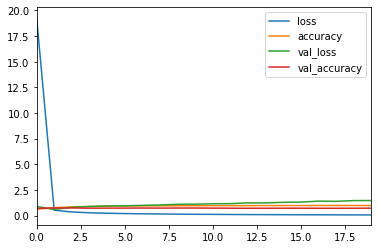

In [11]:
pd.DataFrame(history.history).plot()

In [12]:
x_test, y_test = prepare_data(test_files, minmax_scale)

In [13]:
x_test.shape

(400, 280, 5, 68)

In [14]:
y_test.shape

(400,)

In [15]:
scores = model.evaluate(x_test, y_test, verbose=1)
scores

400/400 [==============================] - ETA: 1s - loss: 1.1038 - accuracy: 0.75 - ETA: 0s - loss: 1.3514 - accuracy: 0.71 - ETA: 0s - loss: 1.1992 - accuracy: 0.75 - 0s 620us/sample - loss: 1.1785 - accuracy: 0.7575


[1.1784819793701171, 0.7575]

In [16]:
y_pred = model.predict(x_test, verbose=1)
y_pred.shape

400/400 [==============================] - ETA:  - ETA:  - 0s 396us/sample


(400, 1)

In [17]:
y_true = []
for i in y_test:
    y_true.append([i])

y_true = np.asarray(y_true)

for i in y_pred:
    print(i)

print(y_true)
print(y_pred)
    

[0.21189898]
[0.0788113]
[0.9991015]
[0.00070091]
[5.7513077e-16]
[0.9997552]
[2.3002583e-05]
[0.46718892]
[0.9184885]
[0.18645276]
[0.01780409]
[0.99999785]
[0.44723353]
[0.84588045]
[0.3515268]
[0.36598745]
[0.9999502]
[0.06361816]
[0.9999857]
[0.99451363]
[0.08342084]
[0.02934453]
[0.822017]
[0.999995]
[0.10504825]
[0.6429118]
[1.]
[0.02477933]
[0.2841652]
[0.99834347]
[2.2108341e-14]
[0.9997948]
[0.16519304]
[1.]
[0.32135475]
[0.99886936]
[0.36215812]
[0.9414529]
[0.45860198]
[1.]
[0.00618806]
[0.04687099]
[0.00786137]
[0.13489734]
[0.43494183]
[0.3555586]
[1.7877699e-07]
[9.573303e-18]
[0.18108052]
[0.97922647]
[0.10146974]
[0.00356114]
[0.9999356]
[0.6193555]
[0.99995816]
[0.98588866]
[1.5875717e-08]
[0.6745679]
[0.43554252]
[1.2561798e-05]
[0.7900827]
[0.3681984]
[1.]
[0.]
[0.69896805]
[0.7395411]
[0.14853412]
[0.00843929]
[0.9999993]
[0.9479824]
[0.03318328]
[1.3511815e-23]
[1.]
[1.5819427e-09]
[0.99260724]
[0.01315317]
[1.8469608e-06]
[5.14911e-05]
[1.]
[0.01208875]
[3.5300303

 [1.00000000e+00]]


In [18]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

In [19]:
matrix

array([[400]], dtype=int64)